# Dataset preparation

In [1]:
import os

Connect to the cloud

In [ ]:
!gcloud auth login

Data

In [22]:
S2Hand_path = "sen1floods11/v1.1/data/flood_events/HandLabeled/S2Hand/"
LabelHand_path = "sen1floods11/v1.1/data/flood_events/HandLabeled/LabelHand/"

os.makedirs(S2Hand_path, exist_ok=True)
os.makedirs(LabelHand_path, exist_ok=True)

In [23]:
!gsutil -m rsync -r gs://sen1floods11/$S2Hand_path $S2Hand_path
!gsutil -m rsync -r gs://sen1floods11/$LabelHand_path $LabelHand_path

Building synchronization state...
Starting synchronization...
Building synchronization state...
Starting synchronization...


Test splits

In [24]:
splits_path = "sen1floods11/v1.1/splits/flood_handlabeled/"
os.makedirs(splits_path, exist_ok=True)

In [25]:
!gsutil -m rsync -r gs://sen1floods11/$splits_path $splits_path

Building synchronization state...
Starting synchronization...


# Step 1 - Basic Statistics

## Number of images in each split and each region

### By split:

In [7]:
import pandas as pd

bolivia_data_path = os.path.join(splits_path, "flood_bolivia_data.csv")
train_data_path = os.path.join(splits_path, "flood_train_data.csv")
val_data_path = os.path.join(splits_path, "flood_valid_data.csv")
test_data_path = os.path.join(splits_path, "flood_test_data.csv")

bolivia_data = pd.read_csv(bolivia_data_path, header=None, names=["scene", "mask"])
train_data = pd.read_csv(train_data_path, header=None, names=["scene", "mask"])
valid_data = pd.read_csv(val_data_path, header=None, names=["scene", "mask"])
test_data = pd.read_csv(test_data_path, header=None, names=["scene", "mask"])

C:\Users\NathanWeinstein\AppData\Local\Temp\ipykernel_13892\1871633075.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [8]:
num_bolivia = bolivia_data.shape[0]
num_train = train_data.shape[0]
num_valid = valid_data.shape[0]
num_test = test_data.shape[0]

print(f"Number of Bolivia scenes: {num_bolivia}")
print(f"Number of training scenes: {num_train}")
print(f"Number of validation scenes: {num_valid}")
print(f"Number of test scenes: {num_test}")

Number of Bolivia scenes: 15
Number of training scenes: 252
Number of validation scenes: 89
Number of test scenes: 90


### By region:

List all files in the S2Hand_path.
Each file follows the naming scheme EVENT_CHIPID_LAYER.tif (e.g. Bolivia_103757_S2Hand.tif) so EVENT is the region.

In [9]:
region_counts = {}

for filename in os.listdir(S2Hand_path):
    if filename.endswith(".tif"):
        region_name = filename.split('_')[0]                                # Extract the region name (EVENT part of the filename)
        region_counts[region_name] = region_counts.get(region_name, 0) + 1

In [10]:
df = pd.DataFrame.from_dict(region_counts, orient='index', columns=['Count'])
df.index.name = 'Region'
df.reset_index(inplace=True)
df

,Region,Count
0,Bolivia,15
1,Ghana,53
2,India,68
3,Mekong,30
4,Nigeria,18
5,Pakistan,28
6,Paraguay,67
7,Somalia,26
8,Spain,30
9,Sri-Lanka,42


## Per-channel mean and standard deviation.

In [11]:
import utils

In [12]:
scenes, _ = utils.get_scenes_arr(S2Hand_path)
scenes.shape

(446, 13, 512, 512)

In [13]:
scenes = utils.dn2reflectance(scenes)   # not necessary and more memory consuming but is a good practice

In [14]:
means = scenes.mean(axis=(0, 2, 3))
std_devs = scenes.std(axis=(0, 2, 3))

In [15]:
wavelengths = utils.get_satellite_wavelength("sentinel2")
bands_names = utils.get_bands_names(wavelengths)

In [16]:
bands_stats = pd.DataFrame({"band": bands_names, 'mean': means, 'std': std_devs})
bands_stats

,band,mean,std
0,B01,0.161226,0.069464
1,B02,0.137989,0.073459
2,B03,0.134443,0.073161
3,B04,0.119516,0.086060
4,B05,0.143917,0.077136
5,B06,0.234425,0.092163
6,B07,0.279647,0.108803
7,B08,0.257841,0.102925
8,B8A,0.302382,0.120511
9,B09,0.047673,0.033169


## Probability of water (based on labels)

### Per image (scene)

In [17]:
scenes_masks, chip_ids = utils.get_scenes_arr(LabelHand_path)
scenes_masks.shape

(446, 1, 512, 512)

In [18]:
water_probabilities = utils.calc_water_probabilities(scenes_masks)

In [19]:
water_probabilities_df = pd.DataFrame({'chip_id': chip_ids, 'water_probability': water_probabilities})
water_probabilities_df

,chip_id,water_probability
0,103757,0.40149
1,129334,0.658679
2,195474,0.005935
3,23014,0.03714
4,233925,0.000007
...,...,...
441,908474,0.007044
442,933610,0.01459
443,955053,0.136713
444,986268,0.034686


### Per train/dev(val)/test sets and for the held-out region (Bolivia) 

In [20]:
water_probabilities_df['chip_id'] = water_probabilities_df['chip_id'].astype(int)

In [21]:
print("Average Water Probability for Bolivia:", utils.calc_avg_water_probability(bolivia_data, water_probabilities_df))
print("Average Water Probability for Training Data:", utils.calc_avg_water_probability(train_data, water_probabilities_df))
print("Average Water Probability for Validation Data:", utils.calc_avg_water_probability(valid_data, water_probabilities_df))
print("Average Water Probability for Test Data:", utils.calc_avg_water_probability(test_data, water_probabilities_df))

Average Water Probability for Bolivia: 0.16992148193052953
Average Water Probability for Training Data: 0.09378431582938244
Average Water Probability for Validation Data: 0.11422605626409803
Average Water Probability for Test Data: 0.13514114436380642


# Step 2 - Using NDWI to predict water

In [59]:
test_and_bolivia_data = pd.concat([bolivia_data, test_data])

In [68]:
chip_ids = chip_ids.astype(int)

Filter indices of the scenes_masks and chip_ids arrays to only include the chip_ids from the test_and_bolivia_data

In [74]:
chip_id_to_index = {chip_id: index for index, chip_id in enumerate(chip_ids)}
filtered_indices = [chip_id_to_index[chip_id] for chip_id in test_and_bolivia_data['chip_id'] if chip_id in chip_id_to_index]

filtered_scenes = scenes[filtered_indices]
filtered_scenes_masks = scenes_masks[filtered_indices]
filtered_chip_ids = chip_ids[filtered_indices]

Convert the arrays of scenes back to lists

In [189]:
scenes_list = [filtered_scenes[i] for i in range(filtered_scenes.shape[0])]
scenes_masks_list = [filtered_scenes_masks[i] for i in range(filtered_scenes_masks.shape[0])]

Optimize NDWI threshold

In [193]:
best_threshold, best_acc = utils.optimize_ndwi_threshold(filtered_scenes, filtered_scenes_masks, bands_names)

100%|██████████| 21/21 [00:42<00:00,  2.03s/it]

Optimal NDWI threshold: 0.0 with accuracy of: 0.9806437128121169


In [ ]:
print(f"Optimal NDWI threshold: {best_threshold} with accuracy of: {best_acc}")

Visualize the results (optional)

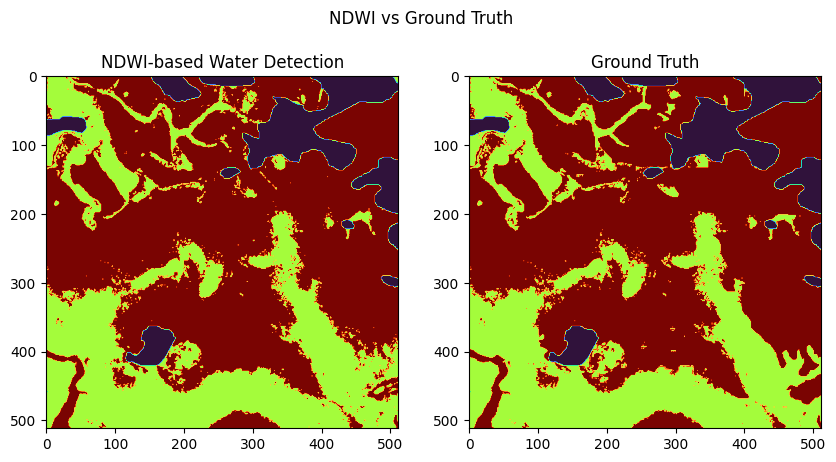

In [194]:
idx = 1
scene = scenes_list[idx]
scene_mask = scenes_masks_list[idx]
utils.visualize_comparison(scene, scene_mask.squeeze(), bands_names, best_threshold)


# Step 3 - Create a TFRecord file

Write the tfrecord for a split

In [2]:
import tfrecord_utils
import os
import pandas as pd

S2Hand_path = "sen1floods11/v1.1/data/flood_events/HandLabeled/S2Hand/"
LabelHand_path = "sen1floods11/v1.1/data/flood_events/HandLabeled/LabelHand/"
splits_path = "sen1floods11/v1.1/splits/flood_handlabeled/"

bolivia_data_path = os.path.join(splits_path, "flood_bolivia_data.csv")

bolivia_data = pd.read_csv(bolivia_data_path, header=None, names=["scene", "mask"])

tfrecord_utils.write_tfrecord(
    "bolivia_data.tfrecord",
    split_df=bolivia_data,
    images_path=S2Hand_path,
    labels_path=LabelHand_path,
)

Decode the TFRecord file for visualization

In [3]:
import tensorflow as tf

raw_dataset = tf.data.TFRecordDataset("bolivia_data.tfrecord")

feature_description = tfrecord_utils.get_feature_description()

parsed_dataset = raw_dataset.map(
    lambda example_proto: tfrecord_utils._parse_function(example_proto, feature_description)
)

idx = 1
parsed_record = next(iter(parsed_dataset.skip(idx)))

image_bytes = parsed_record["image"]
label_bytes = parsed_record["label"]
chip_id = parsed_record["chip_id"]

image = tfrecord_utils.decode_image(image_bytes)
label = tfrecord_utils.decode_label(label_bytes)
chip_id = tfrecord_utils.decode_chip_id(chip_id)

Display the image and label

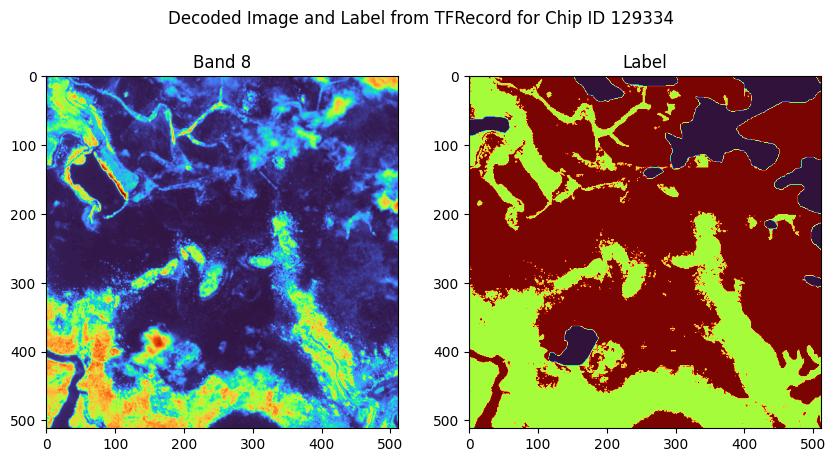

In [7]:
from matplotlib import pyplot as plt

band_number = 8

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image[(band_number - 1), :, :], cmap="turbo")
ax[0].set_title("Band {}".format(band_number))
ax[1].imshow(label, cmap="turbo")
ax[1].set_title("Label")
title = f"Decoded Image and Label from TFRecord for Chip ID {chip_id}"
plt.suptitle(title)
plt.show()